# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "./traffic-signs-data/train.p"
validation_file="./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

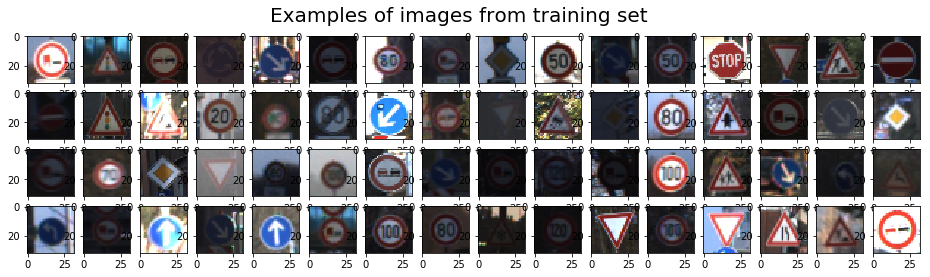

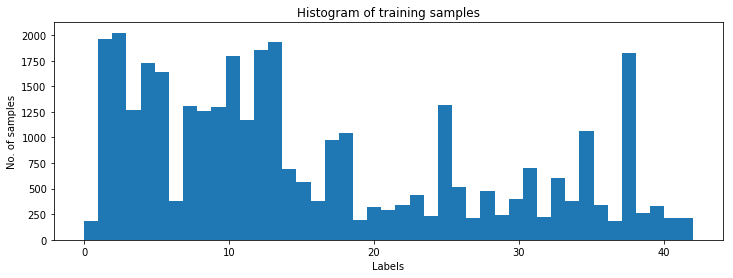

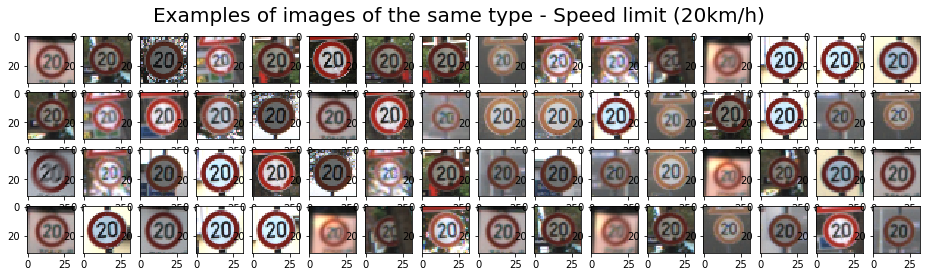

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random 

# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')

def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)
 
    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
       
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)
        
draw_images_examples(X_train, 16, 4, 'Examples of images from training set')
    

fig = plt.figure(figsize=(12,4))
n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Histogram of training samples')

X_train_one_label = X_train[np.where(y_train==0)]
draw_images_examples(X_train_one_label, 16, 4, 'Examples of images of the same type - Speed limit (20km/h)')

## Step 2: Design and Test a Model Architecture

# Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.

### Equalize histograms of training samples - by generation of additional, transformed images

100%|██████████| 43/43 [01:32<00:00,  2.15s/it]


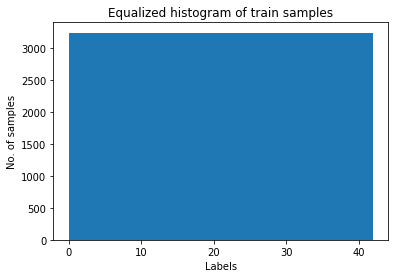

Train set increased from 34799 to 139148


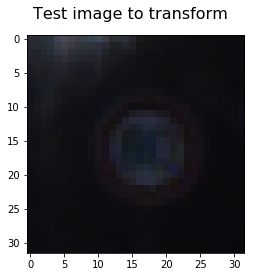

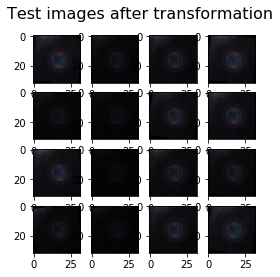

In [5]:
from tqdm import tqdm
from scipy import ndimage
import cv2 

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img):    
    ang_range = 25
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))    
    img = augment_brightness_camera_images(img)
    
    return img

def get_random_image_of_given_label(images_set, labels_set, label):
    image_indexes = np.where(labels_set == label)
    rand_index = random.randint(0, np.bincount(labels_set)[label] - 1)
    return images_set[image_indexes][rand_index]

def equalize_samples_set(X_set, y_set):
    labels_count_arr = np.bincount(y_set)
    labels_bins = np.arange(len(labels_count_arr))
    
    ind = 0    
   
    for label in tqdm(labels_bins):        
        labels_no_to_add =  int(np.mean(labels_count_arr)) * 4 - labels_count_arr[label]
        
        ind = ind + 1
        X_temp = []
        y_temp = []
        
        for num in range(labels_no_to_add):      
            rand_image = get_random_image_of_given_label(X_set, y_set, label)
            X_temp.append(transform_image(rand_image))
            y_temp.append(label)            
   
        X_set = np.append(X_set, np.array(X_temp), axis=0)
        y_set = np.append(y_set, np.array(y_temp), axis=0)
        
    return X_set, y_set


X_train, y_train = equalize_samples_set(X_train, y_train)

n, bins, patches = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Equalized histogram of train samples')
plt.show()

print("Train set increased from {} to {}".format(n_train,X_train.shape[0]))

fig=plt.figure()
fig.suptitle('Test image to transform', fontsize=16)
plt.imshow(X_train[1000])

grid_len = 4
fig=plt.figure(figsize=(grid_len,grid_len))
fig.suptitle('Test images after transformation', fontsize=16)
 
for i in range(1,grid_len*grid_len+1):
    image = transform_image(X_train[1000])
    plt.subplot(grid_len,grid_len,i)
    plt.imshow(image)

### Image normalization and grayscale conversion

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
100%|██████████| 12630/12630 [00:00<00:00, 42148.51it/s]


Sample image dimension BEFORE processing: (32, 32, 3)
Sample image dimension AFTER processing: (32, 32, 1)


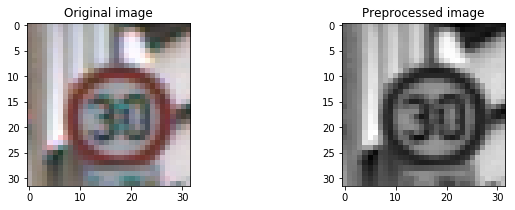

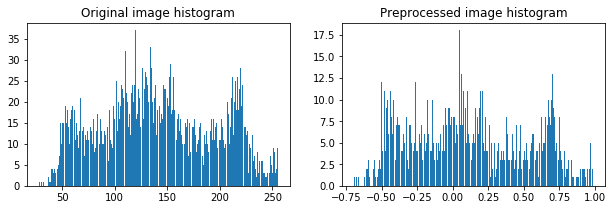

In [6]:
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,None]

def normalize(value):
    return value / 255 * 2 - 1

def preprocess_image(image):
    img = grayscale(image)
    img = normalize(img)
    return img

from tqdm import tqdm
def preprocess_batch(images):
    imgs = np.zeros(shape=images.shape)
    processed_image_depth = preprocess_image(images[0]).shape[2]
    imgs = imgs[:,:,:,0:processed_image_depth]
    for i in tqdm(range(images.shape[0])):
        imgs[i] = preprocess_image(images[i])        
    return imgs

X_train_processed = preprocess_batch(X_train)
X_valid_processed = preprocess_batch(X_valid)
X_test_processed = preprocess_batch(X_test)

no_test_image = 10000

sample_image = X_train[no_test_image]
sample_image_processed = grayscale(X_train[no_test_image])
fig=plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image")
plt.imshow(sample_image)
sub=plt.subplot(132)
sub.set_title("Preprocessed image")
plt.imshow(sample_image_processed.squeeze(), cmap='gray')

print("Sample image dimension BEFORE processing: {}".format(sample_image.shape))
print("Sample image dimension AFTER processing: {}".format(sample_image_processed.shape))

image_depth = X_train_processed.shape[3]

sample_image = X_train[no_test_image]
dim1 = sample_image.shape[0]
dim2 = sample_image.shape[1]
dim3 = sample_image.shape[2]
sample_image_reshaped = np.reshape(sample_image, dim1*dim2*dim3)
plt.figure(figsize=(16,3))
sub=plt.subplot(131)
sub.set_title("Original image histogram")
n, bins, patches = plt.hist(sample_image_reshaped, 255)

sample_image_processed = X_train_processed[no_test_image]
dim1 = sample_image_processed.shape[0]
dim2 = sample_image_processed.shape[1]
dim3 = sample_image_processed.shape[2]
sample_image_processed_reshaped = np.reshape(sample_image_processed, dim1*dim2*dim3)
sub=plt.subplot(132)
sub.set_title("Preprocessed image histogram")
n, bins, patches = plt.hist(sample_image_processed_reshaped,255)

### Model Architecture

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 200
BATCH_SIZE = 128

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
        
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


x = tf.placeholder(tf.float32, (None, 32, 32, image_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.003

logits = LeNet(x)

varss = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in varss
                    if '_b' not in v.name ]) * 0.0001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + lossL2
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH; 1; Valid.Acc.; 0.939; Loss; 0.26322
EPOCH; 2; Valid.Acc.; 0.962; Loss; 0.12049
EPOCH; 3; Valid.Acc.; 0.974; Loss; 0.53041
EPOCH; 4; Valid.Acc.; 0.979; Loss; 0.08538
EPOCH; 5; Valid.Acc.; 0.980; Loss; 0.08335
EPOCH; 6; Valid.Acc.; 0.983; Loss; 0.20889
EPOCH; 7; Valid.Acc.; 0.983; Loss; 0.18031
EPOCH; 8; Valid.Acc.; 0.985; Loss; 0.08685
EPOCH; 9; Valid.Acc.; 0.980; Loss; 0.08807
EPOCH; 10; Valid.Acc.; 0.981; Loss; 0.10688
EPOCH; 11; Valid.Acc.; 0.976; Loss; 0.13078
EPOCH; 12; Valid.Acc.; 0.980; Loss; 0.08739
EPOCH; 13; Valid.Acc.; 0.981; Loss; 0.08850
EPOCH; 14; Valid.Acc.; 0.988; Loss; 0.13577
EPOCH; 15; Valid.Acc.; 0.987; Loss; 0.13509
EPOCH; 16; Valid.Acc.; 0.979; Loss; 0.08596
EPOCH; 17; Valid.Acc.; 0.988; Loss; 0.08500
EPOCH; 18; Valid.Acc.; 0.989; Loss; 0.08479
EPOCH; 19; Valid.Acc.; 0.987; Loss; 0.27819
EPOCH; 20; Valid.Acc.; 0.984; Loss; 0.09104
EPOCH; 21; Valid.Acc.; 0.987; Loss; 0.08966
EPOCH; 22; Valid.Acc.; 0.978; Loss; 0.08908
EPOCH; 23; Valid.Acc.; 0.983

EPOCH; 186; Valid.Acc.; 0.992; Loss; 0.06976
EPOCH; 187; Valid.Acc.; 0.992; Loss; 0.06837
EPOCH; 188; Valid.Acc.; 0.990; Loss; 0.06825
EPOCH; 189; Valid.Acc.; 0.986; Loss; 0.08122
EPOCH; 190; Valid.Acc.; 0.988; Loss; 0.07205
EPOCH; 191; Valid.Acc.; 0.989; Loss; 0.06879
EPOCH; 192; Valid.Acc.; 0.990; Loss; 0.06747
EPOCH; 193; Valid.Acc.; 0.987; Loss; 0.06928
EPOCH; 194; Valid.Acc.; 0.991; Loss; 0.06738
EPOCH; 195; Valid.Acc.; 0.993; Loss; 0.06839
EPOCH; 196; Valid.Acc.; 0.990; Loss; 0.06769
EPOCH; 197; Valid.Acc.; 0.984; Loss; 0.07616
EPOCH; 198; Valid.Acc.; 0.992; Loss; 0.06889
EPOCH; 199; Valid.Acc.; 0.993; Loss; 0.06999
EPOCH; 200; Valid.Acc.; 0.991; Loss; 0.06805
Model saved
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.951


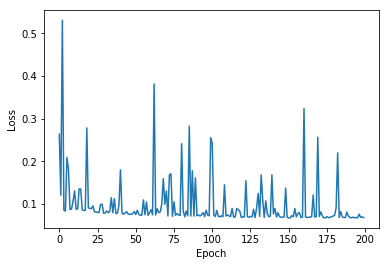

In [11]:
from sklearn.utils import shuffle

cost_arr = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            to, cost = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH; {}; Valid.Acc.; {:.3f}; Loss; {:.5f}".format(i+1, validation_accuracy, cost))
        cost_arr.append(cost)
      
        
    saver.save(sess, './lenet')
    print("Model saved")


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
plt.plot(cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_train_processed, y_train)
    print("Train Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 0.990


In [9]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_valid_processed, y_valid)
    print("CV Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
CV Accuracy = 0.991


In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.951


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten

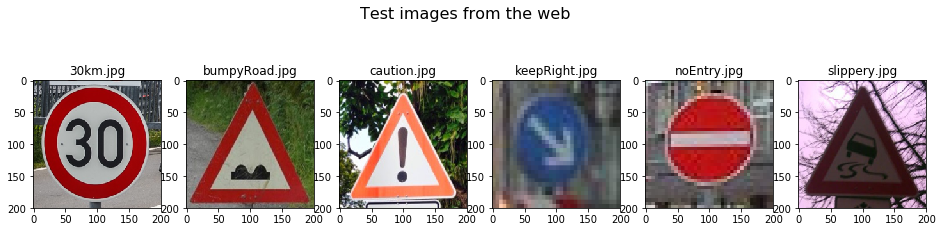

In [12]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

img_folder = './examples/'
test_images = []
test_responses = [1, 22, 18, 38, 17, 23]
fig = plt.figure(figsize=(16,4))
fig.suptitle('Test images from the web', fontsize=16)


cnt = 0
for img_name in os.listdir(img_folder):
    image = mpimg.imread(img_folder+img_name)
    image_to_show = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    cnt = cnt+1
    sub=plt.subplot(1,6,cnt)
    sub.set_title(img_name)
    plt.imshow(image_to_show)
    image = preprocess_image(image) 
    test_images.append(image)
    
    
test_images = np.array(test_images)
   

### Predict the Sign Type for Each Image

In [13]:
   
pred_val = tf.argmax(logits, 1)
pred_softmax = tf.nn.softmax(logits)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_val_out, pred_topFive_out = sess.run( [pred_val, pred_topFive], feed_dict={x:  test_images, y: test_responses})
    
print("Predicted Labels")
print(pred_val_out)
print()


with open('signnames.csv') as csvfile:
    next(csvfile) # ignore header
    a = [ row.strip().split(',') for row in csvfile]
    signnames_dict = dict((data[0],data[1:]) for data in a)
    
cnt = 0
correct_cnt = 0
for i in pred_val_out:
    correctness = "Correct"
    if test_responses[cnt] == i:
        correctness = "Correct"
        correct_cnt = correct_cnt + 1
    else:
        correctness = "Not correct!"
      
    print("{} - {} -> {}".format(i, signnames_dict[str(i)], correctness))
    cnt = cnt + 1
    

INFO:tensorflow:Restoring parameters from ./lenet
Predicted Labels
[ 1 22 18 38 17 23]

1 - ['Speed limit (30km/h)'] -> Correct
22 - ['Bumpy road'] -> Correct
18 - ['General caution'] -> Correct
38 - ['Keep right'] -> Correct
17 - ['No entry'] -> Correct
23 - ['Slippery road'] -> Correct


### Analyze Performance

In [14]:
print("Accuracy for the tested images equals: {:.2f} %".format(correct_cnt/cnt*100)) 

Accuracy for the tested images equals: 100.00 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Top 5 softmax probabilities for fach test image
TopKV2(values=array([[  9.99966383e-01,   2.34676299e-05,   3.53801079e-06,
          2.47478192e-06,   9.41128917e-07],
       [  9.99997377e-01,   2.64594996e-06,   2.64094413e-09,
          7.55810914e-10,   3.23054000e-10],
       [  1.00000000e+00,   1.23742585e-12,   5.63498731e-14,
          6.64969957e-18,   4.81106029e-18],
       [  9.99995708e-01,   3.86851298e-06,   1.78813934e-07,
          8.83431426e-08,   7.20927034e-08],
       [  1.00000000e+00,   5.18782621e-11,   1.51859742e-12,
          3.47871553e-13,   2.03839170e-13],
       [  9.99951839e-01,   4.73668151e-05,   4.94106871e-07,
          2.10263934e-07,   1.16615176e-07]], dtype=float32), indices=array([[ 1,  2, 13,  0,  6],
       [22, 29, 31, 28, 26],
       [18, 27, 26, 19, 28],
       [38, 39, 36,  2,  0],
       [17, 14, 41, 12, 10],
       [23, 30, 11, 25, 21]], dtype=int32))


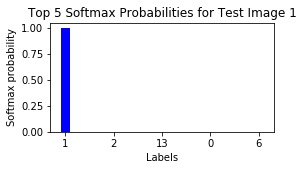

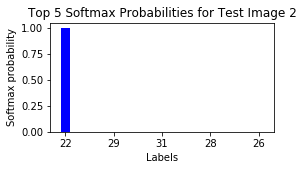

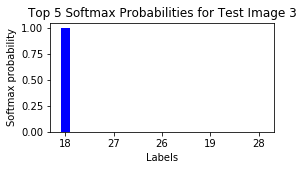

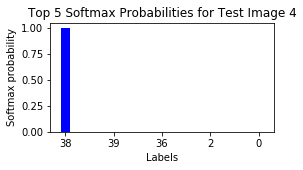

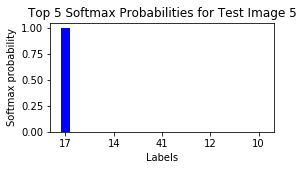

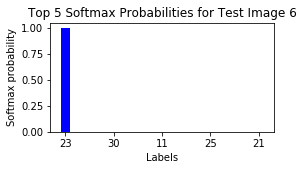

In [15]:
print('Top 5 softmax probabilities for fach test image')
print(pred_topFive_out)

top_k_values = pred_topFive_out[0]
top_k_indices = pred_topFive_out[1]

ind = np.arange(5) 

for i in range(6):
    plt.figure(figsize=(4,2))
    values = top_k_values[i]
    plt.bar(ind, values, 0.2, color='b')
    plt.ylabel('Softmax probability')
    plt.xlabel('Labels')
    plt.title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    plt.xticks(ind, tuple(top_k_indices[i]))

plt.show()